In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt

from tools.misc_tools import get_h5_data
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import LinearNDInterpolator


# **Windowing Technique:**

In [2]:

from tools.misc_tools import get_fpath_sim
from tools.plotter import plot_from_array
from tools.solvers.kolmogorov import TimeStepper3D
import copy 

material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 32}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']

fields = ['p', 'c11', 'c12', 'c22', 'u', 'v']

p = data_fields['p'][-1,:,:,:] - base_flow['p'][[0], None, :]
c11 = data_fields['c11'][-1,:,:,:] - base_flow['c11'][[0], None, :]
c12 = data_fields['c12'][-1,:,:,:] - base_flow['c12'][[0], None, :]
c22 = data_fields['c22'][-1,:,:,:] - base_flow['c22'][[0], None, :]

trace = c11 + c22 


2025-02-23 22:26:07,127 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


In [3]:
Lx = system_params['Lx']
Nz = solver_params['Nz']

In [4]:
from cfd_tools.cartesian_systems.misc_tools import shift_reflect

mean_c22_y = np.mean(c22, axis=(0,1))

Ny = mean_c22_y.shape[0]
if mean_c22_y[0] > mean_c22_y[Ny//2]:
    # u = shift_reflect(u, parity='odd')
    # v = shift_reflect(v, parity='even')
    p = shift_reflect(p, parity='even')
    trace = shift_reflect(trace, parity='even')
    c22 = shift_reflect(c22, parity='even')

In [5]:
def draw_surface(array1, x, y, z, ax=None, level_mult=0.7, color='tab:blue'):

    level_val = (np.max(array1) - np.min(array1)) * level_mult + np.min(array1)

    try:
        verts, faces, _, _ = marching_cubes(array1, level=level_val, step_size=1, spacing=(x[1]-x[0], y[1]-y[0], z[1]-z[0]))
        
        verts[:, 0] += x[0]
        verts[:, 1] += y[0]
        verts[:, 2] += z[0]

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        ls = LightSource(azdeg=45.0, altdeg=245.0)
        mesh = Poly3DCollection(verts[faces], shade=True, lightsource=ls, facecolors=color)

        ax.add_collection3d(mesh)
    except:
        pass

    return verts, level_val

In [6]:

def plot_3D_surface(array1, x, y, z, ax=None, level_mult=0.7):
    if not np.all(np.isclose(np.diff(x, n=2), 0)) or not np.all(np.isclose(np.diff(y, n=2), 0)) or not np.all(np.isclose(np.diff(z, n=2), 0)):
        raise Exception("Grids not equally spaced. Marching Cube Algorithm will be weird...")
    x, y, z = x, z, y

    if ax is None:
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect((np.max(x)-np.min(x), np.max(y)-np.min(y), np.max(z)-np.min(z)), zoom=0.9)
        ax.set_xlabel("x", labelpad=20, fontsize=32)
        ax.set_ylabel("z", labelpad=40, fontsize=32)
        ax.set_zlabel("y",labelpad=10, fontsize=32)
        
        ax.set_xlim(np.min(x), np.max(x))  
        ax.set_zlim(np.min(z), np.max(z)) 
        ax.set_ylim(np.min(y), np.max(y))  

        ax.view_init(elev=30, azim=25, roll=0)

        ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=20)
        ax.set_zticks([-np.pi, 0, np.pi, ], [r'$-\pi$', '0', r'$\pi$'], fontsize=20)
        ax.set_yticks([0, 1*np.pi, 2*np.pi, -1*np.pi, -2*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$-\pi$', r'$-2\pi$'], fontsize=20)
        
    if isinstance(level_mult, float): 
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult, 'tab:blue')
    elif isinstance(level_mult, list):
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult[0], 'tab:blue')
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult[1], 'tab:red')

    plt.tight_layout()

    return ax, verts, level_val

In [7]:
# Tile the periodic solution...

trace_trans = np.roll(trace, shift=-6, axis=0)
trace_trans = np.roll(trace_trans, shift=-7, axis=1)
trace_tiled = np.tile(trace_trans, (1, 5, 1))

trace_tiled = trace_tiled[:, Nz//2:-Nz//2, :]

# Tile the periodic solution...
p_trans = np.roll(p, shift=-6, axis=0)
p_trans = np.roll(p_trans, shift=-7, axis=1)
p_tiled = np.tile(p_trans, (1, 5, 1))

x_tiled = x
y_tiled = y
z_tiled = np.concatenate([z-2*np.pi, z-1*np.pi, z , z+1*np.pi, z+2*np.pi])[Nz//2:-Nz//2]
p_tiled = p_tiled[:, Nz//2:-Nz//2, :]




In [8]:
# ax = plot_3D_surface(trace_trans, x, y, z, ax=None, level_mult=0.4)


/tmp/ipykernel_327/1172887681.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


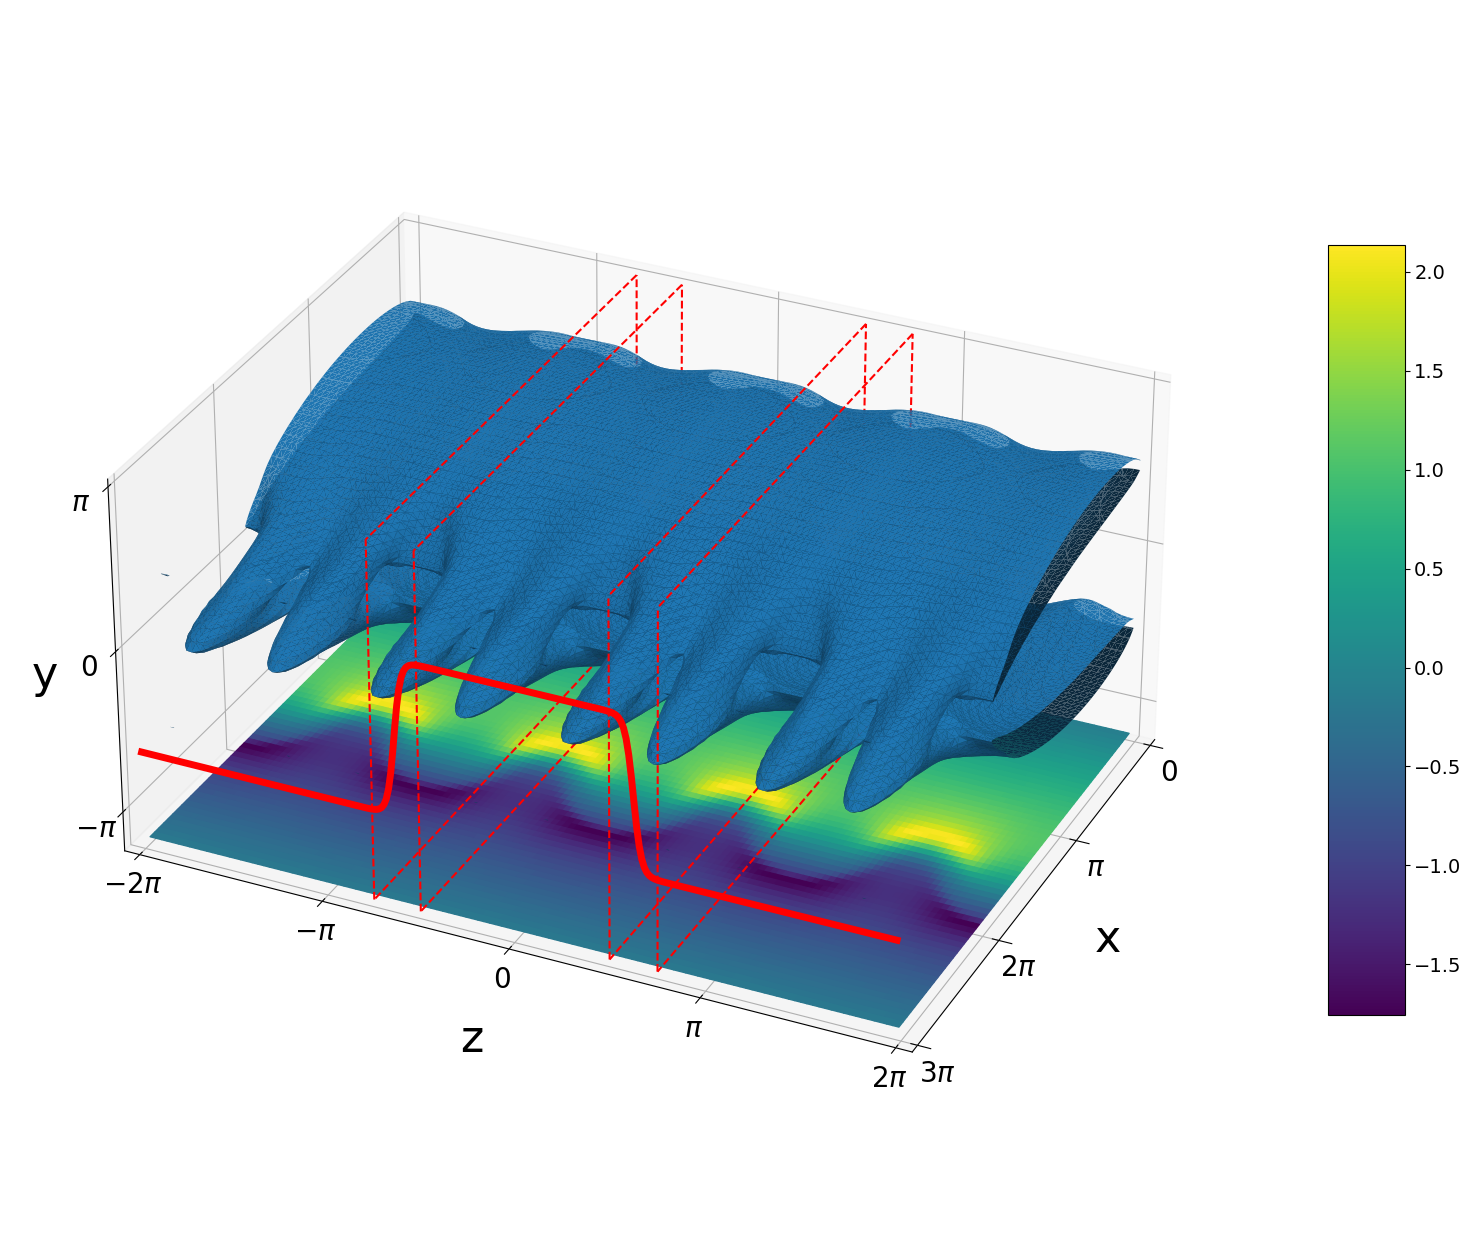

In [10]:
a, b = np.pi/2, np.pi/4
plt.rcParams['font.size'] = 40

ax, verts, level_val = plot_3D_surface(trace_tiled, x_tiled, y_tiled, z_tiled, ax=None, level_mult=0.41)
ax.computed_zorder = False

ax.set_zlim((-1.2*np.pi, np.pi))
#### Plot windowing function

z_plot = np.linspace(np.min(z_tiled), np.max(z_tiled), 300)
window = 1/4 * (1 + np.tanh(6 * (a - z_plot) / b + 3)) * (1 + np.tanh(6 * (a + z_plot) / b + 3))

color = 'red'
ax.plot(z_plot, (window*3-2), zs=Lx, zdir='x', color=color, zorder=10, linewidth=5)
ax.plot([-a, -a], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)
ax.plot([-a, -a], [-1.2*np.pi, np.pi], zs=0, zdir='x', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [-a, -a], zs=-1.2*np.pi, zdir='z', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [-a, -a], zs=np.pi, zdir='z', color=color, linestyle='--', zorder=10)
ax.plot([a, a], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)
ax.plot([a, a], [-1.2*np.pi, np.pi], zs=0, zdir='x', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [a, a], zs=-1.2*np.pi, zdir='z', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [a, a], zs=np.pi, zdir='z', color=color, linestyle='--', zorder=10)
ax.plot([-a-b, -a-b], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)
ax.plot([-a-b, -a-b], [-1.2*np.pi, np.pi], zs=0, zdir='x', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [-a-b, -a-b], zs=-1.2*np.pi, zdir='z', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [-a-b, -a-b], zs=np.pi, zdir='z', color=color, linestyle='--', zorder=10)

ax.plot([a+b, a+b], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)
ax.plot([a+b, a+b], [-1.2*np.pi, np.pi], zs=0, zdir='x', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [a+b, a+b], zs=-1.2*np.pi, zdir='z', color=color, linestyle='--', zorder=0.9)
ax.plot([0, 3*np.pi], [a+b, a+b], zs=np.pi, zdir='z', color=color, linestyle='--', zorder=10)

#### Plot midplane pressure
xgrid, zgrid = np.meshgrid(x_tiled, z_tiled, sparse=False, indexing='ij')

cmap_kind = 'viridis'
cmap = plt.get_cmap(cmap_kind)
field = p_tiled[:,:,Ny//2]
min_val, max_val = np.min(field), np.max(field)
facecolors = cmap((field - min_val) / (max_val - min_val))
ax.plot_surface(xgrid, zgrid, -1.2*np.pi * np.ones_like(xgrid), rstride=1, cstride=1,
                            facecolors=facecolors, shade=False, zorder=0.5)

norm = Normalize(vmin=np.min(field), vmax=np.max(field))
sm = plt.cm.ScalarMappable(cmap=cmap_kind, norm=norm)
sm.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=10)


# Structure of Arrowhead

# Localisation

In [18]:
material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.infty, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': 8*np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']

fields = ['p', 'c11', 'c12', 'c22', 'u', 'v']

plt.figure(figsize=(10, 5))
for field_name in fields:
    base_field = base_flow[field_name]
    field_array = data_fields[field_name][-1,:,:,:] - base_field[:, None, :]
    field_int = np.linalg.norm(field_array, axis=(0,2))
    field_int /= np.max(field_int)

    plt.plot(z, field_int, linewidth=3)

plt.legend(fields)

plt.xlabel('z')
plt.ylabel(r'$|f|_{\infty, x, y}/|f|_{\infty, x, y, z}$')
plt.xticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi], ['-4$\pi$', '-2$\pi$', '0', '2$\pi$', '4$\pi$'])

# core_root, _ = get_roots()
# fpath = os.path.join(core_root, 'images', f'localisation_W_{W}_eps_{eps}_L_{L}_Re_{Re}_beta_{beta}_Lx_{Lx}_Lz_{Lz}_Nx_{Nx}_Ny_{Ny}_Nz_{Nz}.jpg')
# plt.savefig(fpath, bbox_inches='tight')
# plt.close()
    

# How Subcritical is the AH

In [101]:
from tools.misc_tools import get_AH_W_list

W_list_2D = get_AH_W_list(eps=1e-3, beta=0.9, Re=0.5, L=np.infty, Lx=3*np.pi, Nx=128, Ny=256, ndim=2, Nz=None, Lz=None, subdir='arrowhead_2D', suffix='recent-')
W_list_3D = get_AH_W_list(eps=1e-3, beta=0.9, Re=0.5, L=np.infty, Lx=3*np.pi, Nx=64, Ny=64, ndim=3, Nz=128, Lz=8*np.pi, subdir='arrowhead_3D', suffix='recent-localised')


In [102]:
from tools.misc_tools import get_metric_from_params

material_params = {'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 128, 'Ny': 256,}
system_params = {'Lx': 3*np.pi,  'ndim': 2, 'n': 1}

metric_list_2D = []
W_list_2D_plot = []
for W in reversed(W_list_2D):
    material_params['W'] = W
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-', subdir='arrowhead_2D', metric='trace', deviation=True)
    metric_list_2D.append(metric_all[-1])
    W_list_2D_plot.append(W)


material_params = {'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 8*np.pi}

metric_list_3D = []
W_list_3D_plot = []
for W in reversed(W_list_3D):
    material_params['W'] = W
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list_3D.append(metric_all[-1])
    W_list_3D_plot.append(W)



In [104]:
material_params['W'] = 20
data_fields, data_metric = get_h5_data(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', s=-1)

In [105]:
plt.plot(W_list_2D_plot, metric_list_2D, linestyle='--')
plt.plot(W_list_3D_plot, metric_list_3D, linestyle='-')
print(metric_list_3D)
print(W_list_3D_plot)

# Lz Bifurcation Plot

([<matplotlib.axis.XTick at 0x7fd652585d90>,
 [Text(0.0, 0, '0'),
  Text(3.141592653589793, 0, '$\\pi$'),
  Text(6.283185307179586, 0, '$2\\pi$'),
  Text(9.42477796076938, 0, '$3\\pi$'),
  Text(12.566370614359172, 0, '$4\\pi$'),
  Text(15.707963267948966, 0, '$5\\pi$'),
  Text(18.84955592153876, 0, '$6\\pi$'),
  Text(21.991148575128552, 0, '$7\\pi$'),
  Text(25.132741228718345, 0, '$8\\pi$')])

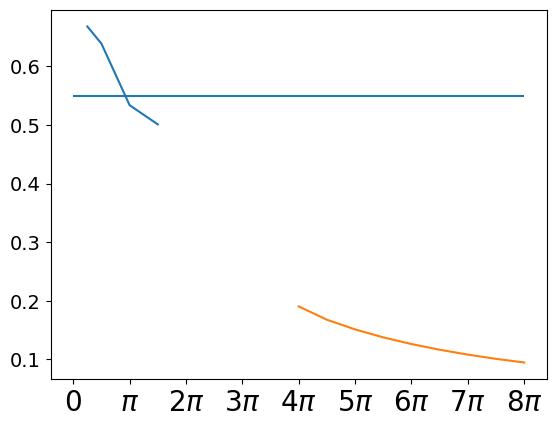

In [19]:
from tools.misc_tools import get_metric_from_params

material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 8*np.pi}

# 2D AH
metric_list = []
Lz_list_plot = [np.pi/8]
Nz_list = [16]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list.append(metric_all[-1])
plt.hlines(metric_list[0], 0, 8*np.pi)

# m=1 mode
metric_list = []
Lz_list_plot = [np.pi/4, np.pi/2, np.pi, 3/2*np.pi]
Nz_list = [16,16,32,32]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list.append(metric_all[-1])
plt.plot(Lz_list_plot, metric_list)

# localised mode
metric_list = []
Lz_list_plot = [8*np.pi, 7.5*np.pi, 7*np.pi, 6.5*np.pi, 6*np.pi, 5.5*np.pi, 5*np.pi, 4.5*np.pi, 4*np.pi]
Nz_list = [128,120,112,104,96,88,80,72,64]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list.append(metric_all[-1])
plt.plot(Lz_list_plot, metric_list)

plt.xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi, 6*np.pi, 7*np.pi, 8*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$', r'$5\pi$', r'$6\pi$',  r'$7\pi$', r'$8\pi$'], fontsize=20)
